In [2]:
# %load ../startup.py
import os,sys
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

os.environ['PYTHONPATH']=os.environ.get('LIB')
if not os.environ.get('LIB') in sys.path: 
    sys.path.insert(0,os.environ.get('LIB'))

DAT_DIR = os.environ.get('DAT_DIR')    

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
%load_ext rpy2.ipython

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 
from matplotlib import gridspec
from scipy.interpolate import splev, splrep
import xlwt
import seaborn as sns
from scipy import stats
import rpy2.robjects.packages as rpackages
import seaborn as sns
from statsmodels import robust


from heprnhci.db.mongo import *


from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>")) # increase jupyter screen width to 100%
pd.options.display.max_colwidth = 500
pd.set_option('display.precision',2)

HCI=openMongo(db=os.environ.get('MONGO_HCIDB'),host=os.environ.get('MONGO_HOST'),auth=False)


Populating the interactive namespace from numpy and matplotlib


/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


# Goal: QC 

* Outlier detection and removal

* Intraplate
    * Distribution of cv per endpoint
* Interplate
    * Distribution of corrcoef for ctrl+ FC
    * Distribution of AC50 for ctrl+
    



# Data

In [2]:
Res=[]
Res =pd.DataFrame(list(HCI.heprn_raw.find({},dict(_id=0,plate_id=1,timeh=1,samples=1))))
Res.groupby('timeh').aggregate(dict(plate_id=len))
    

,plate_id
timeh,
1,30
3,30
6,30
24,30
48,30
72,30


In [3]:
HCI.heprn_raw.find_one()['wells']

[{'raw_value': 10.1735107849,
  'FA1': 'NS',
  'dsstox_sid': 'DTXSID2021735',
  'name': 'Dimethyl sulfoxide',
  'FN1': 'NuclearSize',
  'channel_name': 'Nuclei',
  'FA0': 'NS2',
  'FN0': 'NuclearSize2',
  'channel_id': 1,
  'casrn': '67-68-5',
  'conc': 0.0,
  'timeh': 24,
  'sample_id': 'DMSO',
  'feature_name': 'MEAN_ObjectSizeCh1',
  'plate_id': 'HCS-UC-W73_160624150001',
  'col': 1,
  'stype': 'ctrl-',
  'row': 0},
 {'raw_value': 10.2149953089,
  'FA1': 'NS',
  'dsstox_sid': 'DTXSID2021735',
  'name': 'Dimethyl sulfoxide',
  'FN1': 'NuclearSize',
  'channel_name': 'Nuclei',
  'FA0': 'NS2',
  'FN0': 'NuclearSize2',
  'channel_id': 1,
  'casrn': '67-68-5',
  'conc': 0.0,
  'timeh': 24,
  'sample_id': 'DMSO',
  'feature_name': 'MEAN_ObjectSizeCh1',
  'plate_id': 'HCS-UC-W73_160624150001',
  'col': 22,
  'stype': 'ctrl-',
  'row': 0},
 {'raw_value': 10.4411913684,
  'FA1': 'NS',
  'dsstox_sid': 'DTXSID2021735',
  'name': 'Dimethyl sulfoxide',
  'FN1': 'NuclearSize',
  'channel_name': '

In [4]:
R0 = []
for X in HCI.heprn_raw.find():   
    R0.append(pd.DataFrame(X['wells']))
R0 = pd.concat(R0)

In [5]:
R0.groupby(['timeh','FN1']).aggregate(dict(dsstox_sid=len))

dsstox_sid
timeh FN1                      
1     Apoptosis            2120
      CellNumber           4240
      DNATexture           2120
      ERStress             2120
      LysosomalMass        2120
      MitoFxnI             2120
      NuclearSize          4240
      Steatosis            2120
3     Apoptosis            2120
      CellNumber           4240
      DNATexture           2120
      ERStress             2120
      LysosomalMass        2120
      MitoFxnI             2120
      NuclearSize          4240
      Steatosis            2120
6     Apoptosis            2120
      CellNumber           4240
      DNATexture           2120
      ERStress             2120
      LysosomalMass        2120
      MitoFxnI             2120
      NuclearSize          4240
      Steatosis            2120
24    Apoptosis            2120
      CellNumber           4240
      DNATexture           2120
      ERStress             2120
      LysosomalMass        2120
      MitoFxnI             2120
      NuclearSize          4240
      Steatosis            2120
48    Apoptosis            2120
      CellNumber           4240
      DNATexture           2120
      ERStress             2120
      LysosomalMass        2120
      MitoFxnI             2120
      NuclearSize          4240
      Steatosis            2120
72    Apoptosis            2120
      CellNumber           4240
      DNATexture           2120
      ERStress             2120
      LysosomalMass        2120
      MitoFxnI             2120
      NuclearSize          4240
      Steatosis            2120

In [6]:
R0[['plate_id','row','col']].drop_duplicates().shape[0] * 4 * 6

1526400

In [10]:
(4+88)*2*6*10*10 

110400

## Outliers

In [11]:
from scipy.stats import iqr

def outHi(X): return np.percentile(X,75)+1.5*iqr(X)
def outLo(X): return np.percentile(X,25)-1.5*iqr(X)


In [13]:
Res = []
for X in HCI.heprn_raw.find():
    print(X['plate_id'])
    R0 = pd.DataFrame(X['wells'])\
            .pivot_table(index=['dsstox_sid','sample_id','name','timeh',
                            'stype','conc','row','col'],
                         columns='FN1',
                         values='raw_value')
    for ft in R0.columns:
        hi,lo = outHi(R0[ft]),outLo(R0[ft])
        nhi,nlo=(R0[ft]<lo).sum(),(R0[ft]>hi).sum()
        R = dict(plate_id=X['plate_id'],timeh=X['timeh'],
                 ft=ft,n_gt_hi=nhi,n_lt_lo=nlo,n=R0.shape[0])
        Res.append(R)
OUT0=pd.DataFrame(Res)
OUT0.loc[:,'nout']=OUT0.n_gt_hi+OUT0.n_lt_lo
OUT0.loc[:,'fout']=OUT0.nout/OUT0.n*1.0

HCS-UC-W73_160624150001
HCS-UC-W73_160624160002
HCS-UC-W73_160625080001
HCS-UC-W73_160625080002
HCS-UC-W73_160628150001
HCS-UC-W73_160629070001
HCS-UC-W73_160712160001
HCS-UC-W73_160712170001
HCS-UC-W73_160712170002
HCS-UC-W73_160712180001
HCS-UC-W73_160713080001
HCS-UC-W73_160713080002
HCS-UC-W73_160713090001
HCS-UC-W73_160713090002
HCS-UC-W73_160713090003
HCS-UC-W73_160713100001
HCS-UC-W73_160713100002
HCS-UC-W73_160713100003
HCS-UC-W73_160713110001
HCS-UC-W73_160713110002
HCS-UC-W73_160713110003
HCS-UC-W73_160713120001
HCS-UC-W73_160713170001
HCS-UC-W73_160713170002
HCS-UC-W73_160714170001
HCS-UC-W73_160720080001
HCS-UC-W73_160720160001
HCS-UC-W73_160720170001
HCS-UC-W73_160721130002
HCS-UC-W73_160721160001
HCS-US-W71_160624150001
HCS-US-W71_160624190001
HCS-US-W71_160625080002
HCS-US-W71_160628170001
HCS-US-W71_160629070001
HCS-US-W71_160706080001
HCS-US-W71_160706090001
HCS-US-W71_160706090002
HCS-US-W71_160706090003
HCS-US-W71_160706100001
HCS-US-W71_160706100002
HCS-US-W71_16071

In [14]:
OUT0.groupby(['plate_id','timeh']).aggregate(dict(fout=np.mean,nout=sum))

,,fout,nout
plate_id,timeh,,
HCS-UC-W73_160624150001,24,0.09,100
HCS-UC-W73_160624160002,24,0.08,88
HCS-UC-W73_160625080001,72,0.07,28
HCS-UC-W73_160625080002,72,0.10,39
HCS-UC-W73_160628150001,48,0.08,117
...,...,...,...
VTIW03_160721130001,48,0.09,107
VTIW03_160721160001,72,0.10,65
VTIW03_160727100001,1,0.02,4


In [15]:
OUT0.head()

,plate_id,timeh,ft,n_gt_hi,n_lt_lo,n,nout,fout
0,HCS-UC-W73_160624150001,24,CellNumber,30,0,380,30,0.08
1,HCS-UC-W73_160624150001,24,NuclearSize,33,3,380,36,0.09
2,HCS-UC-W73_160624150001,24,Steatosis,4,30,380,34,0.09
3,HCS-UC-W73_160624160002,24,CellNumber,24,0,380,24,0.06
4,HCS-UC-W73_160624160002,24,NuclearSize,26,9,380,35,0.09


In [21]:
import seaborn as sns

/opt/miniconda3/envs/tiptox/lib/python3.8/site-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


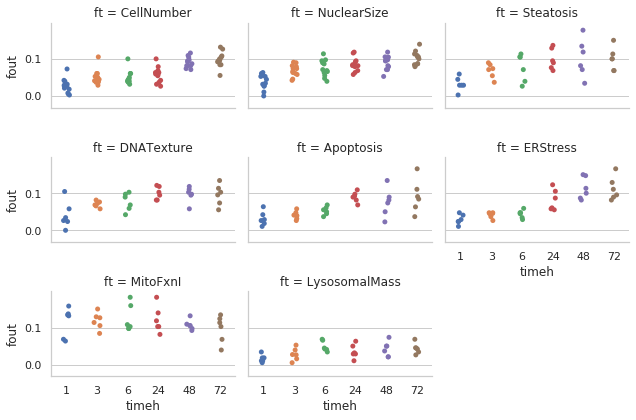

In [16]:
sns.set(style='whitegrid')

g=sns.catplot(x='timeh',y='fout',data=OUT0,col='ft',col_wrap=3,size=2,aspect=1.5)
#sns.catplot(x='timeh',y='n_lt_lo',data=OUT0,row='ft',size=2,aspect=2,
#            color='green')
g.savefig(FIG_DIR+'heprn-outlier-frac-v1a.png')

### Outlier summary

* there is a time-dependent increase in outliers
* less than 10% of points are outliers across all plates
* label outliers for later evaluation in conc-response analysis

# Distribution of CVs intraplate

In [18]:
Res = []
def cv(X): return np.std(X)/np.mean(X)

for X in HCI.heprn_raw.find(dict(timeh={'$in':[24,48,72]})):
    print(X['plate_id'])
    R0 = pd.DataFrame(X['wells'])\
            .groupby(['dsstox_sid','sample_id','name','timeh',
                      'stype','FN1'])\
            .aggregate(dict(raw_value=cv))
    Res.append(R0.reset_index())
CV0=pd.concat(Res)
CV0.rename(columns=dict(raw_value='cv'),inplace=True)

HCS-UC-W73_160624150001
HCS-UC-W73_160624160002
HCS-UC-W73_160625080001
HCS-UC-W73_160625080002
HCS-UC-W73_160628150001
HCS-UC-W73_160629070001
HCS-UC-W73_160713080001
HCS-UC-W73_160713110001
HCS-UC-W73_160720160001
HCS-UC-W73_160720170001
HCS-UC-W73_160721130002
HCS-UC-W73_160721160001
HCS-US-W71_160624150001
HCS-US-W71_160624190001
HCS-US-W71_160625080002
HCS-US-W71_160628170001
HCS-US-W71_160629070001
HCS-US-W71_160713140001
HCS-US-W71_160714170002
HCS-US-W71_160714170003
HCS-US-W71_160714170004
HCS-US-W71_160714180001
HCS-US-W71_160719150001
HCS-US-W71_160720060001
HCS-US-W71_160720060002
HCS-US-W71_160720060003
HCS-US-W71_160720070001
HCS-US-W71_160720070002
HCS-US-W71_160720070003
HCS-US-W71_160720080001
HCS-US-W71_160720090001
HCS-US-W71_160720160001
HCS-US-W71_160720170001
HCS-US-W71_160721130001
HCS-US-W71_160721130002
HCS-US-W71_160721160001
HCS-US-W71_160722160001
HCS-US-W71_160726160001
HCS-US-W72_160624170001
HCS-US-W72_160624170002
HCS-US-W72_160624180001
HCS-US-W72_16062

In [19]:
#d.DataFrame(list(HCI.chemicals.find(dict(stype='ctrl+'),dict(_id=0))))

In [18]:
#CV0.head()

In [19]:
X = CV0.groupby(['timeh','FN1','stype']).aggregate(dict(cv=[np.mean]))

## Overall intraplate CVs

In [21]:
CV0.replace(dict(stype={'chem_test':'test chem','ctrl+':'pos. ctrl','ctrl-':'DMSO'}),inplace=True)
X = CV0[CV0.stype!='pos. ctrl'].pivot_table(index=['timeh','stype'],columns='FN1',
                values='cv',aggfunc=np.mean)
   #.query("stype!='ctrl+'")\
X.insert(X.shape[1],'Ave. cv (time)',X.mean(axis=1))   
X.loc[('','Ave. cv (endpoint)'),:] = X.mean(axis=0)
X.to_excel(SUP_DIR+'S2-heprn-intra-plate-cv-stype.xlsx')
X

FN1                       Apoptosis  CellNumber  DNATexture  ERStress  \
timeh stype                                                             
24    DMSO                     0.27        0.09        0.11      0.19   
      test chem                0.25        0.08        0.16      0.19   
48    DMSO                     0.43        0.10        0.14      0.31   
      test chem                0.34        0.13        0.23      0.28   
72    DMSO                     0.36        0.10        0.14      0.23   
      test chem                0.40        0.16        0.26      0.30   
      Ave. cv (endpoint)       0.34        0.11        0.17      0.25   

FN1                       LysosomalMass  MitoFxnI  NuclearSize  Steatosis  \
timeh stype                                                                 
24    DMSO                         0.15      0.03         0.03       0.08   
      test chem                    0.14      0.10         0.03       0.12   
48    DMSO                         0.18      0.03         0.02       0.07   
      test chem                    0.11      0.10         0.05       0.11   
72    DMSO                         0.14      0.07         0.03       0.07   
      test chem                    0.10      0.12         0.08       0.13   
      Ave. cv (endpoint)           0.14      0.08         0.04       0.10   

FN1                       Ave. cv (time)  
timeh stype                               
24    DMSO                          0.12  
      test chem                     0.13  
48    DMSO                          0.16  
      test chem                     0.17  
72    DMSO                          0.14  
      test chem                     0.19  
      Ave. cv (endpoint)            0.15

In [22]:
B = ''
for i,x in X.loc[('')].iloc[:,:-1].T.sort_values('Ave. cv (endpoint)').round(decimals=2).reset_index().iterrows():
    B += " %s (%3.2f)," % tuple(x)
B

' NuclearSize (0.04), MitoFxnI (0.08), Steatosis (0.10), CellNumber (0.11), LysosomalMass (0.14), DNATexture (0.17), ERStress (0.25), Apoptosis (0.34),'

## Summary of CV intraplate

* The mean CVs for all endpoints across all time points was 0.13, and it varied from 0.04 for NS to 0.30 for Apoptosis
* The CVs for all endpoints showed a time-dependent increase 


# Inter-plate CV

Use the effect information to determine the CV for the same treatment across plates using stype='ctrl+'

In [43]:
#HCI.heprn_ch.find_one()
FT = pd.DataFrame(list(HCI.hci_feats.find({},dict(_id=0))))

In [11]:
Res = []
def cv(X): return np.std(X)/np.mean(X)

for X in HCI.heprn_ch.find():
    print X['plate_id']
    R0 = pd.DataFrame(X['chem_ch']).query("stype=='ctrl+'")
    Res.append(R0)
Z0=pd.concat(Res)


HCS-UC-W73_160624150001
HCS-UC-W73_160624160002
HCS-UC-W73_160625080001
HCS-UC-W73_160625080002
HCS-UC-W73_160628150001
HCS-UC-W73_160629070001
HCS-UC-W73_160712160001
HCS-UC-W73_160712170001
HCS-UC-W73_160712170002
HCS-UC-W73_160712180001
HCS-UC-W73_160713080001
HCS-UC-W73_160713080002
HCS-UC-W73_160713090001
HCS-UC-W73_160713090002
HCS-UC-W73_160713090003
HCS-UC-W73_160713100001
HCS-UC-W73_160713100002
HCS-UC-W73_160713100003
HCS-UC-W73_160713110001
HCS-UC-W73_160713110002
HCS-UC-W73_160713110003
HCS-UC-W73_160713120001
HCS-UC-W73_160713170001
HCS-UC-W73_160713170002
HCS-UC-W73_160714170001
HCS-UC-W73_160720080001
HCS-UC-W73_160720160001
HCS-UC-W73_160720170001
HCS-UC-W73_160721130002
HCS-UC-W73_160721160001
HCS-US-W71_160624150001
HCS-US-W71_160624190001
HCS-US-W71_160625080002
HCS-US-W71_160628170001
HCS-US-W71_160629070001
HCS-US-W71_160706080001
HCS-US-W71_160706090001
HCS-US-W71_160706090002
HCS-US-W71_160706090003
HCS-US-W71_160706100001
HCS-US-W71_160706100002
HCS-US-W71_16071

In [44]:
Z0 = Z0.merge(FT[['FA0','FN1']],on='FA0')

In [48]:
Z0.columns

Index([u'FA0', u'conc', u'ctrl_n_mad', u'ctrl_n_mean', u'ctrl_n_std',
       u'ctrl_p_mad', u'ctrl_p_mean', u'ctrl_p_std', u'dsstox_sid', u'index',
       u'l2fc_ctrl', u'l2fc_plt', u'lconc', u'name', u'pct_ctrl', u'pct_ctrl1',
       u'pct_plt', u'pct_plt1', u'plt_mad', u'plt_mean', u'plt_std',
       u'pv_n_ctrl', u'pv_plt', u'raw_cv', u'raw_mean', u'sample_id', u'stype',
       u'timeh', u'z_ctrl', u'z_plt', u'FN1'],
      dtype='object')

In [45]:
Res = []
def cv(X): return np.abs(np.std(X)/np.mean(X))

X0 = Z0[Z0.timeh>6].pivot_table(index=['timeh','stype'],columns='FN1',
                    values='z_plt',aggfunc=cv)

In [46]:
X0

,FN1,Apoptosis,CellNumber,DNATexture,ERStress,LysosomalMass,MitoFxnI,NuclearSize,Steatosis
timeh,stype,,,,,,,,
24,ctrl+,1.61,2.08,1.57,1.50,4.09,1.63,1.39,1.54
48,ctrl+,5.73,1.28,1.49,4.24,3.27,1.57,1.94,5.69
72,ctrl+,5.28,1.28,1.47,5.78,5.03,2.21,1.76,2.16


In [47]:
Z0[Z0.timeh>6].pivot_table(index=['timeh','stype'],columns='FN1',
                    values='z_ctrl',aggfunc=cv)

,FN1,Apoptosis,CellNumber,DNATexture,ERStress,LysosomalMass,MitoFxnI,NuclearSize,Steatosis
timeh,stype,,,,,,,,
24,ctrl+,2.14,2.01,1.49,1.26,5.81,1.58,1.27,1.34
48,ctrl+,4.99,1.25,1.84,4.91,3.47,1.30,1.75,5.38
72,ctrl+,3.26,1.20,1.82,3.61,24.96,2.14,1.57,2.52


In [50]:
Z0[Z0.timeh>6].pivot_table(index=['timeh','stype'],columns='FN1',
                    values='l2fc_plt',aggfunc=cv)

,FN1,Apoptosis,CellNumber,DNATexture,ERStress,LysosomalMass,NuclearSize,Steatosis
timeh,stype,,,,,,,
24,ctrl+,2.46,2.16,2.25,1.89,8.44,1.41,1.48
48,ctrl+,NaN,NaN,2.03,NaN,7.64,NaN,NaN
72,ctrl+,NaN,NaN,1.91,NaN,12.33,NaN,NaN
